In [9]:
from myclasses.sql_executor import SQLExecutor
import pandas as pd

if __name__ == "__main__":
    # Create an instance of SQLExecutor
    sql_executor = SQLExecutor()

    # Example SQL query
    query = """
        SELECT 
            gross_revenue,
            fiscal_year,
            ownership,
            tot_days,
            tot_days_title_v,
            tot_days_title_xviii,
            tot_days_title_xix,
            num_beds,
            tot_bed_days_avail,
            snf_num_beds,
            snf_admis_tot,
            snf_avg_stay_len_title_tot,
            snf_days_total,
            tot_discharge_tot,
            snf_discharge_tot,
            tot_salaries,
            overhead_nonsalary_costs,
            cash,
            acct_rec,
            acct_payable,
            tot_current_assets,
            tot_fixed_assets,
            tot_assets,
            tot_liabilities,
            contract_labor,
            total_operating_expense,
            loc_type,
            current_ratio,
            deficiency_score,
            overall_rating,
            county_ssa,
            zip,
            resfamcouncil,
            sprinkler_status,
            chow_last_12mos,
            fine_cnt,
            fine_tot,
            tot_penlty_cnt,
            state,
            survey_rating,
            quality_rating,
            staffing_rating,
            rn_staffing_rating,
            aidhrd,
            vochrd,
            rnhrd,
            totlichrd,
            tothrd,
            pthrd,
            weighted_all_cycles_score,
            certification,
            bedcert,
            region,
            snf_size

        FROM Master
        ORDER BY prov_id;
        """

    # Execute the query and get the result as a DataFrame
    df = sql_executor.execute_query(query)

# Assuming NA contract_labor means the Nursing home does have contract_labor
df[['contract_labor']] = df[['contract_labor']].fillna(0)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select columns where data type is text (object)
text_columns = df.select_dtypes(include=['object']).columns

# Create dummy variables for text columns
df_encoded = pd.get_dummies(df, columns=text_columns)

# Convert all columns to numeric type
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

# Extract target variable (y) and independent variables (X)
y = df_encoded['gross_revenue']
X = df_encoded.iloc[:, 2:]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Define XGBoost regressor and set hyperparameters
xgb_model = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.065,
    max_depth=4,
    min_child_weight=1,
    subsample=0.85,
    colsample_bytree=0.95,
    random_state=42,
    eval_metric='mae',
    objective='reg:squarederror',
    early_stopping= 20,
    gamma=0.15,              # Regularization parameter
    reg_alpha=0.1,           # L1 regularization
    reg_lambda=0.1          # L2 regularization
)

# Train the model with progress printout and early stopping
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Evaluation set for tracking progress
    verbose=True,  # Print progress
)

[0]	validation_0-mae:4145868.35960	validation_1-mae:4189465.04058
[1]	validation_0-mae:3918090.64404	validation_1-mae:3963303.17099
[2]	validation_0-mae:3707379.81656	validation_1-mae:3753732.97089


/home/josh/.local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:47:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "early_stopping" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-mae:3513410.68682	validation_1-mae:3560751.13794
[4]	validation_0-mae:3334601.06055	validation_1-mae:3382667.52363
[5]	validation_0-mae:3169452.59434	validation_1-mae:3218516.65055
[6]	validation_0-mae:3017107.75112	validation_1-mae:3066046.14187
[7]	validation_0-mae:2877492.63583	validation_1-mae:2926273.19377
[8]	validation_0-mae:2749355.15578	validation_1-mae:2796736.40279
[9]	validation_0-mae:2632579.04671	validation_1-mae:2678648.09581
[10]	validation_0-mae:2524747.27177	validation_1-mae:2569231.32213
[11]	validation_0-mae:2427108.05442	validation_1-mae:2470644.01331
[12]	validation_0-mae:2338547.63494	validation_1-mae:2381615.35110
[13]	validation_0-mae:2256942.61121	validation_1-mae:2300194.52458
[14]	validation_0-mae:2183957.95286	validation_1-mae:2227505.83066
[15]	validation_0-mae:2117791.15510	validation_1-mae:2160360.68350
[16]	validation_0-mae:2056742.06303	validation_1-mae:2098262.48943
[17]	validation_0-mae:2001943.90396	validation_1-mae:2042896.72024
[1

In [ ]:
import numpy as np
from sklearn.metrics import r2_score, median_absolute_error, max_error, mean_absolute_error, mean_squared_error, explained_variance_score

# Predict on test set
y_pred = xgb_model.predict(X_test)

# R² Score (Coefficient of Determination)
r2 = r2_score(y_test, y_pred)

# Median Absolute Error
mdae = median_absolute_error(y_test, y_pred)

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Root Mean Squared Error: ${:.2f}".format(rmse))
print("Median Absolute Error: ${:.2f}".format(mdae))
print("Mean Absolute Error: ${:.2f}".format(mae))
print("Mean Absolute Percentage Error: ${:.2f}".format(mape))
print("R² Score (Coefficient of Determination): {:.5f}".format(r2))

Root Mean Squared Error: $2158520.64
Median Absolute Error: $747810.50
Mean Absolute Error: $1202909.05
Mean Absolute Percentage Error: $12.09
R² Score (Coefficient of Determination): 0.87385


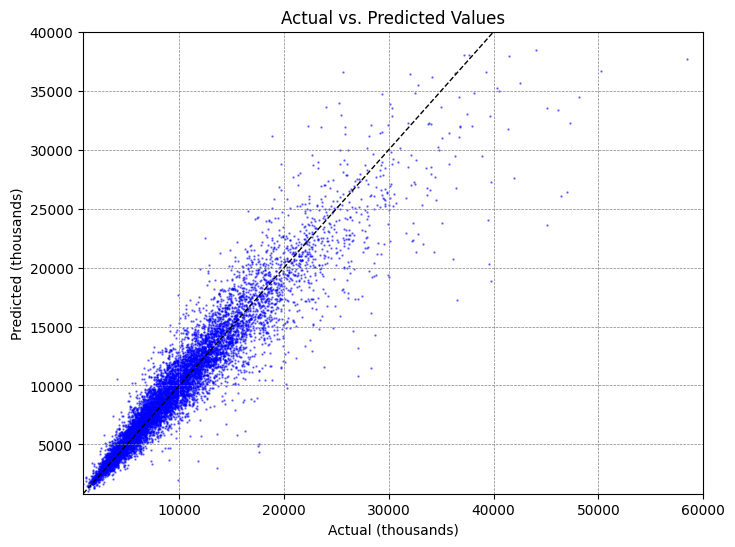

In [ ]:
import matplotlib.pyplot as plt

# Convert values to thousands
y_test_thousands = y_test / 1000
y_pred_thousands = y_pred / 1000

plt.figure(figsize=(8, 6))
plt.scatter(y_test_thousands, y_pred_thousands, color='blue', alpha=0.5, s=0.5)  # Scatter plot of actual vs. predicted values with smaller point size
plt.plot([y_test_thousands.min(), y_test_thousands.max()], [y_test_thousands.min(), y_test_thousands.max()], 'k--', lw=1)  # Plot the diagonal line
plt.xlabel('Actual (thousands)')
plt.ylabel('Predicted (thousands)')
plt.title('Actual vs. Predicted Values')

# Set axis limits to show the actual values
plt.xlim(left=y_test_thousands.min(), right=60000)
plt.ylim(bottom=y_test_thousands.min(), top=40000)

# Add light gridlines
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()

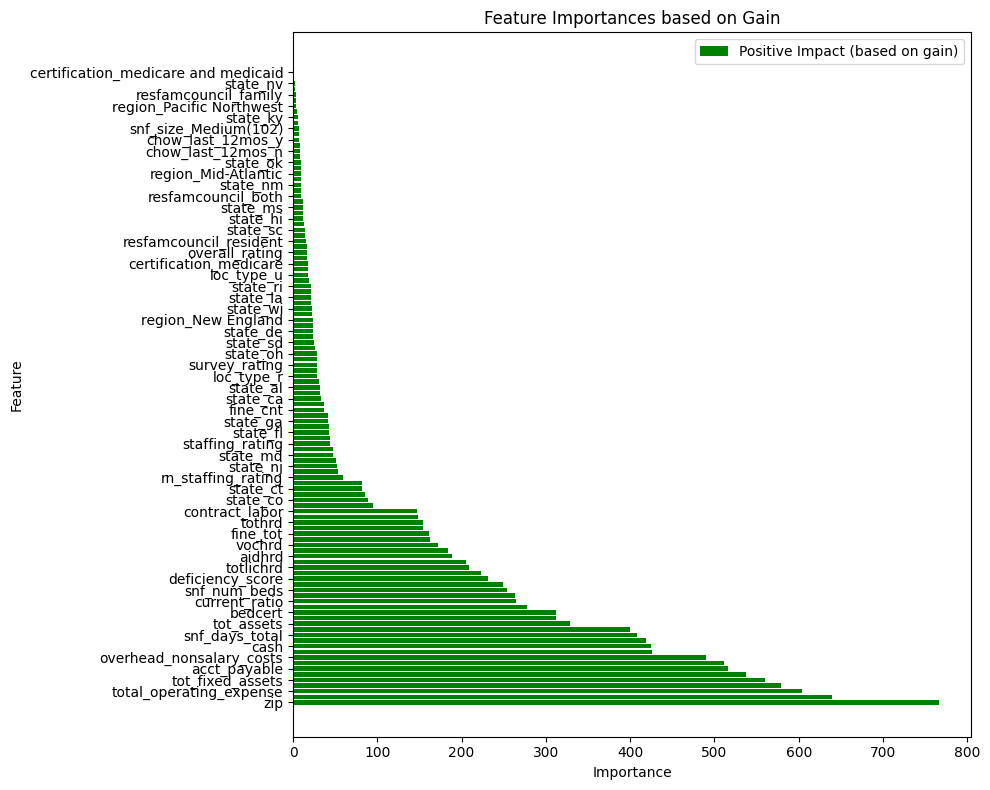

In [ ]:
# Get feature importances based on gain
feature_importances_gain = xgb_model.get_booster().get_score()

# Sort the dictionary by importances in descending order
sorted_feature_importance_gain = sorted(feature_importances_gain.items(), key=lambda x: x[1], reverse=True)

# Separate positive and negative importances (since gain is inherently positive)
positive_importances_gain = dict(sorted_feature_importance_gain)

# Extract feature names and importances
positive_features_gain, positive_importances_gain = zip(*positive_importances_gain.items())

# Plot positive importances based on gain
plt.figure(figsize=(10, 8))
plt.barh(positive_features_gain, positive_importances_gain, color='green', label='Positive Impact (based on gain)')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances based on Gain')
plt.legend()

# Increase spacing between y-axis ticks by skipping every other tick
plt.yticks(range(0, len(positive_features_gain), 2), positive_features_gain[::2])  # Skip every other tick

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
print(sorted_feature_importance_gain)

[('zip', 766.0), ('tot_days_title_xix', 640.0), ('total_operating_expense', 604.0), ('acct_rec', 579.0), ('tot_fixed_assets', 560.0), ('tot_salaries', 537.0), ('acct_payable', 516.0), ('tot_days_title_xviii', 511.0), ('overhead_nonsalary_costs', 490.0), ('tot_days', 426.0), ('cash', 425.0), ('tot_liabilities', 419.0), ('snf_days_total', 408.0), ('county_ssa', 400.0), ('tot_assets', 329.0), ('tot_current_assets', 312.0), ('bedcert', 312.0), ('rnhrd', 277.0), ('current_ratio', 265.0), ('snf_admis_tot', 263.0), ('snf_num_beds', 254.0), ('pthrd', 249.0), ('deficiency_score', 231.0), ('weighted_all_cycles_score', 223.0), ('totlichrd', 209.0), ('snf_avg_stay_len_title_tot', 205.0), ('aidhrd', 189.0), ('snf_discharge_tot', 184.0), ('vochrd', 172.0), ('tot_discharge_tot', 162.0), ('fine_tot', 161.0), ('tot_bed_days_avail', 154.0), ('tothrd', 154.0), ('num_beds', 148.0), ('contract_labor', 147.0), ('state_mi', 95.0), ('state_co', 89.0), ('state_tx', 85.0), ('state_ct', 82.0), ('state_pa', 82.0)